In [108]:
# Allows to make changes to the classes without restarting the notebook 💀 # TODO: Delete once done
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [110]:
from continuous_model.Bee import BeeSwarm
from continuous_model.Hive import Hive
from continuous_model.Model import ForagerModel
from continuous_model.Resource import Resource
from continuous_model.config import *

In [111]:
# Workaround for TQDM's nested loops
from IPython.core.display import HTML

display(HTML("""
    <style>
        .jp-OutputArea-child:has(.jp-OutputArea-prompt:empty) {
              padding: 0 !important;
        }
    </style>
"""))

## Colony survival after one day

In [112]:
STORM_PROBABILITIES = np.linspace(0.0, 0.2, 10) # TODO: CHange last number to 21
RESOURCE_DISTANCES = np.linspace(0.0, 1000.0, 10) # TODO: Change last number to 21
COLONY_SURVIVAL = np.zeros((len(STORM_PROBABILITIES), len(RESOURCE_DISTANCES)))

INITIAL_COLONY_SIZE = 100
TIMESTEPS = 10 # TODO: Change to 1440

In [113]:
hive_config = HiveConfig()
beeswarm_config = BeeSwarmConfig()
resource_config = ResourceConfig()

In [114]:
for (i, p_storm) in tqdm(enumerate(STORM_PROBABILITIES), total=len(STORM_PROBABILITIES), ascii=' >=', leave=True):
    for (j, res_dist) in enumerate(RESOURCE_DISTANCES):
        model_config = ModelConfig(n_resource_sites=0, p_storm=p_storm, n_beeswarms_initial=INITIAL_COLONY_SIZE)
        model.create_agent(Resource, location=(1000 - res_dist, 900))

        model = ForagerModel(model_config, hive_config, beeswarm_config, resource_config)
        
        for _ in range(TIMESTEPS):
            model.step()
        
        n_bee_agents = len(model.get_agents_of_type(BeeSwarm))
        fraction_colony_survived = n_bee_agents / INITIAL_COLONY_SIZE
        COLONY_SURVIVAL[i, j] = fraction_colony_survived

  0%|          | 0/10 [00:00<?, ?it/s]

Bee died by outside risk
Bee died by outside risk


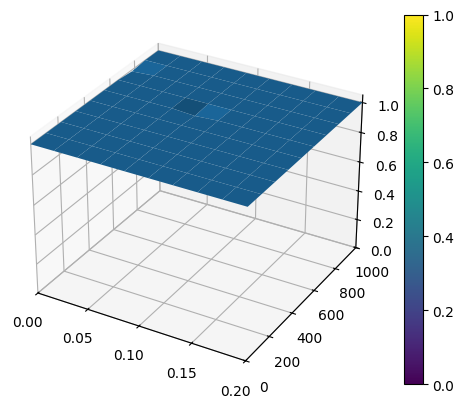

In [126]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# STORM_PROBABILITIES, RESOURCE_DISTANCES = np.meshgrid(STORM_PROBABILITIES, RESOURCE_DISTANCES)

surf = ax.plot_surface(STORM_PROBABILITIES, RESOURCE_DISTANCES, COLONY_SURVIVAL)

ax.set_xlim(0, 0.2)
ax.set_xticks(np.linspace(0, 0.2, 5))
ax.set_ylim(0, 1000)
ax.set_zlim(0, 1.05)

fig.colorbar(surf, shrink=1, aspect=20)
plt.show()